# Assignment 3 Part 2 - Find complex answers to medical questions

## Objectives of this assignment

In assignment 3 you will work on a general answer selection task. Given a question and a list of sentences, the final goal is to predict which of these sentences from the list can be used as part of the answer to the question. Assignment 3 is divided into two parts. Part 1 will help you get familiar with the data, and Part 2 requires you to implement deep neural networks.

The data is in the file `train.csv`, which is provided in both GitHub repository and in iLearn. Each row of the file consists of a question ('qtext' column), an answer ('atext' column), and a label ('label' column) that indicates whether the  answer is correctly related to the question (1) or not (0).

The following code uses pandas to store the file `train.csv` in a data frame and shows the first few rows of data.

In [2]:
import pandas as pd
dataset = pd.read_csv("data/train.csv")
dataset.head()

,qtext,label,atext
0,What are the symptoms of gastritis?,1,"However, the most common symptoms include: Nau..."
1,What are the symptoms of gastritis?,0,var s_context; s_context= s_context || {}; s_c...
2,What are the symptoms of gastritis?,0,"!s_sensitive, chron ID: $('article embeded_mod..."
3,What does the treatment for gastritis involve?,1,Treatment for gastritis usually involves: Taki...
4,What does the treatment for gastritis involve?,1,Eliminating irritating foods from your diet su...


# Now let's get started.

Use the provided files `train.csv`, `val.csv`, and `test.csv` in the data.zip file for all the tasks below.

# Task 1 (8 marks): Simple Siamese NN - Contrastive Loss

Implement a simple TensorFlow-Keras neural model that meets the following requirements:

1. (0.5 marks) An input layer that will accept the tf.idf of paired data. The input of the Siamese network is a pair of data, i.e., (qtext, atext). 
2. (2 marks) Use two hidden layers and a ReLU activation function. You need to determine the size of the hidden layers in {64, 128, 256} using val data, assuming these two layers use the same hidden size.
3. (0.5 marks) Use Euclidean-distance-based contrastive loss to train the model.
4. (0.5 marks) Use Sigmoid function for classification.
5. (1 mark) Calculate prediction accuracy.
6. (1.5 marks) Give an example of failure case, and explain the possible reason and discuss potential solution. 
7. (1 mark) Good coding style as explained in the above Assessment Section.
8. (1 mark) Correctly feeding data into your model, and correctly training and testing of your models.

Use the test data to report the final accuracy of your best model.

In [3]:
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Dense, Lambda
import tensorflow as tf
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
import pandas as pd
import keras
import keras_tuner as kt
import tensorflow.keras.backend as K
from sklearn.metrics import accuracy_score

# Load the datasets
train_df = pd.read_csv("data/train.csv")
val_df = pd.read_csv("data/val.csv")
test_df = pd.read_csv("data/test.csv")

# TF-IDF transformation
vectorizer = TfidfVectorizer(max_features=1000)
train_qtext = vectorizer.fit_transform(train_df['qtext']).toarray()
train_atext = vectorizer.transform(train_df['atext']).toarray()
val_qtext = vectorizer.transform(val_df['qtext']).toarray()
val_atext = vectorizer.transform(val_df['atext']).toarray()
test_qtext = vectorizer.transform(test_df['qtext']).toarray()
test_atext = vectorizer.transform(test_df['atext']).toarray()

train_labels = train_df['label'].values
val_labels = val_df['label'].values
test_labels = test_df['label'].values

input_shape = train_qtext.shape[1]

In [4]:
def euclidean_distance(vectors):
    x, y = vectors
    return K.sqrt(K.sum(K.square(x - y), axis=1, keepdims=True))

def Myloss(margin=1):
    """Provides 'contrastive_loss' an enclosing scope with variable 'margin'.

    Arguments:
        margin: Integer, defines the baseline for distance for which pairs
                should be classified as dissimilar. - (default is 1).

    Returns:
        'contrastive_loss' function with data ('margin') attached.
    """

    # Contrastive loss = mean( (1-true_value) * square(prediction) +
    #                         true_value * square( max(margin-prediction, 0) ))
    def contrastive_loss(y_true, y_pred):
        """Calculates the contrastive loss.

        Arguments:
            y_true: List of labels, each label is of type float32.
            y_pred: List of predictions of same length as of y_true,
                    each label is of type float32.

        Returns:
            A tensor containing contrastive loss as floating point value.
        """

        square_pred = K.square(y_pred)
        margin_square = K.square(K.maximum(margin - (y_pred), 0))
        return K.mean((1 - y_true) * 0.5*square_pred + (y_true)*0.5 * margin_square)

    return contrastive_loss

In [5]:
# Define the Siamese model
def build_siamese_model(hp):
    hidden_size = hp.Choice('hidden_size', values=[64, 128, 256])

    # Input layers for question and answer text
    input_q = keras.Input(shape=(train_qtext.shape[1],), name="q_input")
    input_a = keras.Input(shape=(train_atext.shape[1],), name="a_input")
    
    # Shared layers
    shared_dense1 = keras.layers.Dense(hidden_size, activation="relu")
    shared_dense2 = keras.layers.Dense(hidden_size, activation="relu")
    
    # Processing both inputs through shared layers
    encoded_q = shared_dense1(input_q)
    encoded_q = shared_dense2(encoded_q)
    
    encoded_a = shared_dense1(input_a)
    encoded_a = shared_dense2(encoded_a)
    
    # Output layer with Sigmoid activation for binary classification
    merged = Lambda(function=euclidean_distance, output_shape=(1,),name='merge_layer')([encoded_q, encoded_a])
    output = Dense(1, activation='sigmoid', name='classification_layer')(merged)
    
    model = keras.Model(inputs=[input_q, input_a], outputs=output)
    model.compile(optimizer="adam", loss=Myloss(margin=1.0), metrics=["accuracy"])
    return model

# Hyperparameter tuning
tuner = kt.BayesianOptimization(
    build_siamese_model,
    objective=kt.Objective('val_accuracy', 'max'),
    max_trials=5,
    num_initial_points=2,
    overwrite=True) #True to start afresh


# Perform the search
tuner.search([train_qtext, train_atext], train_labels, 
             validation_data=([val_qtext, val_atext], val_labels), 
             epochs=5)

topN = 1
for x in range(topN):
    print(tuner.get_best_hyperparameters(topN)[x].values)
    print(tuner.get_best_models(topN)[x].summary())

Trial 5 Complete [00h 00m 07s]
val_accuracy: 0.6044142842292786

Best val_accuracy So Far: 0.6044142842292786
Total elapsed time: 00h 00m 31s
{'hidden_size': 256}


/Applications/anaconda3/lib/python3.11/site-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 14 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ q_input             │ (None, 1000)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ a_input             │ (None, 1000)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 256)       │    256,256 │ q_input[0][0],    │
│                     │                   │            │ a_input[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 256)       │     65,792 │ dense[0][0],      │
│                     │                   │            │ dense[1][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ merge_layer         │ (None, 1)         │          0 │ dense_1[0][0],    │
│ (Lambda)            │                   │            │ dense_1[1][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ classification_lay… │ (None, 1)         │          2 │ merge_layer[0][0] │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 322,050 (1.23 MB)

 Trainable params: 322,050 (1.23 MB)

 Non-trainable params: 0 (0.00 B)

None


In [6]:
# Best model and testing
best_model = tuner.get_best_models(num_models=1)[0]
test_predictions = best_model.predict([test_qtext, test_atext]).argmax(axis=1)
test_accuracy = accuracy_score(test_labels, test_predictions)
print("Test Accuracy:", test_accuracy)

# Example of a failure case
sample_idx = np.where(test_predictions != test_labels)[0][0]
print("Question:", test_df.iloc[sample_idx]['qtext'])
print("Answer:", test_df.iloc[sample_idx]['atext'])
print("Predicted Label:", test_predictions[sample_idx])
print("Actual Label:", test_labels[sample_idx])

161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Test Accuracy: 0.5402880498248346
Question: How does an external catheter help male incontinence?
Answer: External catheters.
Predicted Label: 0
Actual Label: 1


Final accuracy of the best Siamese neural network model is approximately 54%.
- Possible reason for the displayed failure case: The answer is very brief, and the model may have difficulty addressing the  relationship due to limited contextual information and medical knowledge.
- Potential solution: 
    - Use Pretrained Contextual Embeddings: Instead of TF-IDF, use pretrained embeddings like BERT embeddings, which capture semantic context better and are likely to improve understanding of shorter phrases.
    - Fine-tune a Domain-Specific Model: For technical or medical content, fine-tuning on a relevant dataset (e.g., medical texts) might help the model develop a better grasp of the domain-specific terms and implied meanings. This can be achieved by fine-tuning on a medical version of BERT, such as BioBERT, before applying it to the answer selection task.

# Task 2 (12 marks): Transformer

In this task, let's use Transformer to predict whether two sentences are related or not. Implement a simple Transformer neural network that meets the following requirements:

1. (1 mark) Each input for this model should be a concatenation of qtext and atext. Use [SEP] to separate qtext and atext, e.g., "Can high blood pressure bring on heart failure? [SEP] Hypertensive heart disease is the No." You need to pad the input to a fixed length. How do you determine a suitable length?
2. (1.5 marks) Choose a suitable tokenizer and justify your choice.
3. (1 mark) An embedding layer that generates embedding vectors of the sentence text into size 128. Remember to add position embedding.
4. (1 mark) One transformer encoder layer, you need to find a hidden dimension in {64, 128, 256}. Use 3 heads in MultiHeadAttention.
5. (1 mark) Do we need a transformer decoder layer for this task? If yes, find a hidden dimension in {64, 128, 256} and use 3 heads in MultiHeadAttention. If no, explain why.
6. (0.5 marks) 1 hidden layer with size 256 and ReLU activation function.
7. (0.5 marks) 1 output layer with size 2 for binary classification to predict whether two inputs are related or not. 
8. (1 mark) Choose a suitable loss to train the model
9. (1 mark) Report your best accuracy on the test split.
10. (1.5 marks) Give an example of a failure case, and explain the possible reason and discuss a potential solution.
11. (1 mark) Good coding style as explained in the above Assessment Section.
12. (1 mark) Correctly feeding data into your model, and correctly training and testing of your models.



In [7]:
from transformers import BertTokenizer
import matplotlib.pyplot as plt

# Load dataset
train_df = pd.read_csv("data/train.csv")

# Tokenizer setup
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

BERT tokenizer is effective at tokenizing text with special tokens like [SEP], and its vocabulary is optimized for sentence-pair tasks.

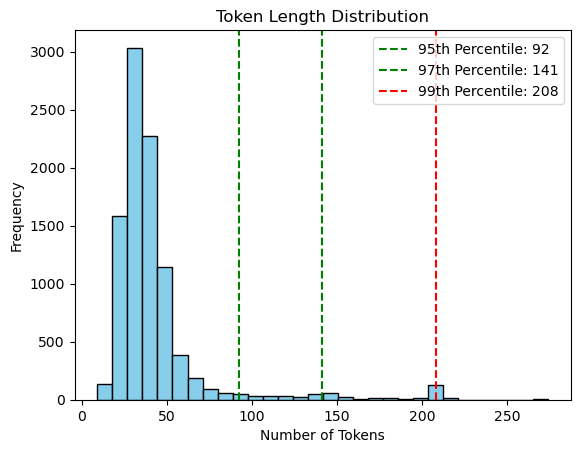

In [8]:
# Concatenate qtext and atext with a [SEP] token in between
texts = train_df['qtext'] + " [SEP] " + train_df['atext']

# Tokenize texts and get length of each tokenized text
token_lengths = [len(tokenizer.encode(text, add_special_tokens=True)) for text in texts]

# Calculate percentiles to determine a suitable length
percentile_95 = int(pd.Series(token_lengths).quantile(0.95))
percentile_97 = int(pd.Series(token_lengths).quantile(0.97))
percentile_99 = int(pd.Series(token_lengths).quantile(0.99))

# Plotting the distribution
plt.hist(token_lengths, bins=30, color='skyblue', edgecolor='black')
plt.axvline(percentile_95, color='green', linestyle='--', label=f'95th Percentile: {percentile_95}')
plt.axvline(percentile_97, color='green', linestyle='--', label=f'97th Percentile: {percentile_97}')
plt.axvline(percentile_99, color='red', linestyle='--', label=f'99th Percentile: {percentile_99}')
plt.title("Token Length Distribution")
plt.xlabel("Number of Tokens")
plt.ylabel("Frequency")
plt.legend()
plt.show()

The difference between the 95th and 97th percentile is not too large, and 141 is not too high, so it is the suitable length.

In [9]:
# Load and preprocess data
train_df = pd.read_csv("data/train.csv")
val_df = pd.read_csv("data/val.csv")
test_df = pd.read_csv("data/test.csv")

max_length = 141
def preprocess_text(dataframe, max_length):
    concatenated_text = dataframe['qtext'] + " [SEP] " + dataframe['atext']
    tokenized = tokenizer(
        concatenated_text.tolist(),
        padding="max_length",
        truncation=True,
        max_length=max_length,
        return_tensors="tf"
    )
    return tokenized["input_ids"], dataframe["label"].values

train_input, train_labels = preprocess_text(train_df, max_length)
val_input, val_labels = preprocess_text(val_df, max_length)
test_input, test_labels = preprocess_text(test_df, max_length)

In [10]:
from tensorflow.keras.layers import Embedding, Dense, Input, LayerNormalization, MultiHeadAttention, Dropout, Add
import keras.ops as ops

# Transformer Model
def build_transformer_model(hp):
    hidden_dim = hp.Choice("hidden_dim", values=[64, 128, 256])
    
    # Input layer
    input_ids = Input(shape=(max_length,), dtype=tf.int32, name="input_ids")
    
    # Embedding layer with positional encoding
    embedding_layer = Embedding(input_dim=tokenizer.vocab_size, output_dim=128)(input_ids)
    pos_encoding = ops.arange(start=0, stop=max_length, step=1)
    pos_encoding = Embedding(input_dim=max_length, output_dim=128)(pos_encoding)
    embedded_input = embedding_layer + pos_encoding
    
    # Transformer Encoder Layer
    attention_output = MultiHeadAttention(num_heads=3, key_dim=hidden_dim)(embedded_input, embedded_input)
    attention_output = Add()([embedded_input, attention_output])
    attention_output = LayerNormalization()(attention_output)
    
    # Hidden Layer
    hidden_layer = Dense(256, activation="relu")(attention_output[:, 0, :])
    
    # Output Layer for Binary Classification
    output = Dense(2, activation="softmax")(hidden_layer)
    
    model = tf.keras.Model(inputs=input_ids, outputs=output)
    model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
    return model

# Hyperparameter tuning
tuner = kt.BayesianOptimization(
    build_transformer_model,
    objective=kt.Objective('val_accuracy', 'max'),
    max_trials=5,
    num_initial_points=2,
    overwrite=True) #True to start afresh


tuner.search(train_input, train_labels, 
             validation_data=(val_input, val_labels), 
             epochs=5)

Trial 5 Complete [00h 05m 01s]
val_accuracy: 0.6138734221458435

Best val_accuracy So Far: 0.6572883725166321
Total elapsed time: 00h 26m 31s


There is no need to add a transformer decoder layer for this task since the decoder is for translation.

In [11]:
# Best model evaluation
best_model = tuner.get_best_models(num_models=1)[0]
test_predictions = best_model.predict(test_input).argmax(axis=1)
test_accuracy = accuracy_score(test_labels, test_predictions)
print("Test Accuracy:", test_accuracy)

# Example of a failure case
sample_idx = np.where(test_predictions != test_labels)[0][0]
print("Question:", test_df.iloc[sample_idx]['qtext'])
print("Answer:", test_df.iloc[sample_idx]['atext'])
print("Predicted Label:", test_predictions[sample_idx])
print("Actual Label:", test_labels[sample_idx])

  1/161 ━━━━━━━━━━━━━━━━━━━━ 19s 124ms/step

/Applications/anaconda3/lib/python3.11/site-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 32 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


161/161 ━━━━━━━━━━━━━━━━━━━━ 9s 53ms/step
Test Accuracy: 0.6161930712339432
Question: How does an external catheter help male incontinence?
Answer: Lots of men hate the idea of using incontinence products -- so-called adult diapers, urine collection bags, and catheters.
Predicted Label: 1
Actual Label: 0


Final accuracy of the best Transformer neural network model is approximately 54%.
- Possible reason for the displayed failure case: The model's attention mechanism may be strongly influenced by specific keywords, like "incontinence" and "catheter," rather than capturing the meaning of the question, which focuses on the “how” aspect. Transformers can sometimes prioritize keyword similarity over deeper semantic matching.
- Potential solution: 
    - Increase Attention to Question Semantics: Explicitly guide the Transformer’s attention by giving more weight to question tokens.
    - Utilize Sentence-BERT (SBERT)